In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

TorchMultimodal Tutorial: Finetuning FLAVA
==========================================


Multimodal AI has recently become very popular owing to its ubiquitous
nature, from use cases like image captioning and visual search to more
recent applications like image generation from text. **TorchMultimodal
is a library powered by Pytorch consisting of building blocks and end to
end examples, aiming to enable and accelerate research in
multimodality**.

In this tutorial, we will demonstrate how to use a **pretrained SoTA
model called** [FLAVA](https://arxiv.org/pdf/2112.04482.pdf) **from
TorchMultimodal library to finetune on a multimodal task i.e. visual
question answering** (VQA). The model consists of two unimodal
transformer based encoders for text and image and a multimodal encoder
to combine the two embeddings. It is pretrained using contrastive, image
text matching and text, image and multimodal masking losses.


Installation
============

We will use TextVQA dataset and `bert tokenizer` from Hugging Face for
this tutorial. So you need to install datasets and transformers in
addition to TorchMultimodal.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>When running this tutorial in Google Colab, install the required packages bycreating a new cell and running the following commands:<pre><code>!pip install torchmultimodal-nightly
!pip install datasets
!pip install transformers</code></pre></p>

</div>



In [2]:
!pip install torchmultimodal-nightly
!pip install datasets
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.5/256.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━

Steps
=====

1.  Download the Hugging Face dataset to a directory on your computer by
    running the following command:

    ``` {.}
    wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
    tar xf vocab.tar.gz
    ```

    
    <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>
    ```
    
    <div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
    ```
    
    <p>If you are running this tutorial in Google Colab, run these commandsin a new cell and prepend these commands with an exclamation mark (!)</p>
    ```
    
    </div>
    ```

2.  For this tutorial, we treat VQA as a classification task where the
    inputs are images and question (text) and the output is an answer
    class. So we need to download the vocab file with answer classes and
    create the answer to label mapping.

    We also load the [textvqa
    dataset](https://arxiv.org/pdf/1904.08920.pdf) containing 34602
    training samples (images,questions and answers) from Hugging Face

We see there are 3997 answer classes including a class representing
unknown answers.


In [4]:
!wget http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz

--2025-01-31 17:08:43--  http://dl.fbaipublicfiles.com/pythia/data/vocab.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.230.202.65, 54.230.202.7, 54.230.202.3, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.230.202.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 596389 (582K) [application/gzip]
Saving to: ‘vocab.tar.gz’

vocab.tar.gz        100%[===================>] 582.41K  2.61MB/s    in 0.2s    

2025-01-31 17:08:44 (2.61 MB/s) - ‘vocab.tar.gz’ saved [596389/596389]



In [6]:
!tar xf vocab.tar.gz

In [9]:
with open("vocabs/answers_textvqa_more_than_1.txt") as f:
  vocab = f.readlines()

answer_to_idx = {}
for idx, entry in enumerate(vocab):
    answer_to_idx[entry.strip("\n")] = idx
print(len(vocab))
print(vocab[:5])

from datasets import load_dataset
dataset = load_dataset("textvqa")

3997
['<unk>\n', 'nokia\n', 'ec\n', 'virgin\n', '2011\n']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

textvqa.py:   0%|          | 0.00/5.02k [00:00<?, ?B/s]

The repository for textvqa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/textvqa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/34602 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5734 [00:00<?, ? examples/s]

Lets display a sample entry from the dataset:


Question:  what year is shown in the photo?
Answers:  ['2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011', '2011']


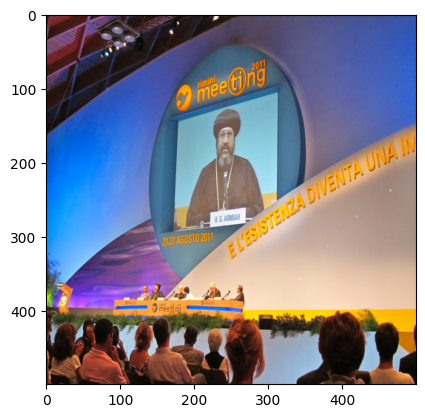

In [10]:
import matplotlib.pyplot as plt
import numpy as np
idx = 5
print("Question: ", dataset["train"][idx]["question"])
print("Answers: " ,dataset["train"][idx]["answers"])
im = np.asarray(dataset["train"][idx]["image"].resize((500,500)))
plt.imshow(im)
plt.show()

3\. Next, we write the transform function to convert the image and text
into Tensors consumable by our model - For images, we use the transforms
from torchvision to convert to Tensor and resize to uniform sizes - For
text, we tokenize (and pad) them using the `BertTokenizer` from Hugging
Face -For answers (i.e. labels), we take the most frequently occurring
answer as the label to train with:


In [11]:
import torch
from torchvision import transforms
from collections import defaultdict
from transformers import BertTokenizer
from functools import partial

def transform(tokenizer, input):
  batch = {}
  # change to a 224 x 224 pixel image
  image_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize([224,224])])
  # convert the color values to RGB
  image = image_transform(input["image"][0].convert("RGB"))
  batch["image"] = [image]
  # the HF tokenizer needs to know to return pytorch tensors
  tokenized=tokenizer(input["question"],return_tensors='pt',padding="max_length",max_length=512)
  batch.update(tokenized)

  ans_to_count = defaultdict(int)
  for ans in input["answers"][0]:
    ans_to_count[ans] += 1
  max_value = max(ans_to_count, key=ans_to_count.get)
  ans_idx = answer_to_idx.get(max_value,0)
  batch["answers"] = torch.as_tensor([ans_idx])
  return batch

# load a pretrained BERT model
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased",padding="max_length",max_length=512)
# a partial transformation function
transform=partial(transform,tokenizer)
# set the transformation function for the dataset
dataset.set_transform(transform)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

4\. Finally, we import the `flava_model_for_classification` from
`torchmultimodal`. It loads the pretrained FLAVA checkpoint by default
and includes a classification head.

The model forward function passes the image through the visual encoder
and the question through the text encoder. The image and question
embeddings are then passed through the multimodal encoder. The final
embedding corresponding to the CLS token is passed through a MLP head
which finally gives the probability distribution over each possible
answers.


In [ ]:
from torchmultimodal.models.flava.model import flava_model_for_classification
model = flava_model_for_classification(num_classes=len(vocab))

5\. We put together the dataset and model in a toy training loop to
demonstrate how to train the model for 3 iterations:


In [ ]:
from torch import nn
BATCH_SIZE = 2
MAX_STEPS = 3
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset["train"], batch_size= BATCH_SIZE)
optimizer = torch.optim.AdamW(model.parameters())


epochs = 1
for _ in range(epochs):
  for idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    out = model(text = batch["input_ids"], image = batch["image"], labels = batch["answers"])
    loss = out.loss
    loss.backward()
    optimizer.step()
    print(f"Loss at step {idx} = {loss}")
    if idx >= MAX_STEPS-1:
      break

Conclusion
==========

This tutorial introduced the basics around how to finetune on a
multimodal task using FLAVA from TorchMultimodal. Please also check out
other examples from the library like
[MDETR](https://github.com/facebookresearch/multimodal/tree/main/torchmultimodal/models/mdetr)
which is a multimodal model for object detection and
[Omnivore](https://github.com/facebookresearch/multimodal/blob/main/torchmultimodal/models/omnivore.py)
which is multitask model spanning image, video and 3d classification.
